<a href="https://colab.research.google.com/github/MikJak75/Neutron_Reflect/blob/main/nr_v12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
!git clone https://github.com/miguel-fc/Neutron_Reflect.git

Cloning into 'Neutron_Reflect'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 125 (delta 4), reused 15 (delta 2), pack-reused 106
Receiving objects: 100% (125/125), 11.36 MiB | 27.49 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [128]:
# Import Python related required packages
import io
import os
import cv2
import gdown
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotly.express as px
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm
import pickle

#Import torch related packages
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset, TensorDataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [129]:
#Set these important parameters
#Dimension of the latent space 
d = 3
#Dimension of the graphs
in_d1 = 2
in_d2 = 96
#Number of epochs
num_epochs = 120
#Number of layers
num_layers = 1
#Number of neurons
num_neur=150 


In [130]:
cd Neutron_Reflect/

/content/Neutron_Reflect/Neutron_Reflect/Neutron_Reflect


In [131]:
#Stored those numpy arrays
data_path = './data/'
sld_arr = np.load(os.path.join(data_path,'sld_fp49.npy'))
params_arr = np.load(os.path.join(data_path,'params_fp49.npy'))

In [132]:
sld_arr.shape, params_arr.shape, sld_arr.dtype, params_arr.dtype

((5942, 2, 96), (5942, 3), dtype('float64'), dtype('float64'))

In [133]:
#Import packages from the github clone
import data_preparation as dpre
import AutoEnc as au
import MLP as mlp

In [134]:
#Prepare data files
xtrain, ytrain, xval, yval, xtest, ytest = \
dpre.split_input_arrays(sld_arr,params_arr, size_split=0.8)

xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape
(4753, 2, 96) (4753, 3) (594, 2, 96) (594, 3) (595, 2, 96) (595, 3)


In [135]:
#Prepare data files, continuation
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = \
dpre.get_dataloaders_fromsplitarrays(xtrain,ytrain,xval,yval,xtest,ytest,batch_size=50)

In [136]:
loss_fn = torch.nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [137]:
def initialize_model(d,in_d1,in_d2,num_layers,num_neur):
  lr= 0.001
  torch.manual_seed(0)
  
  encoder = au.Encoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)
  decoder = au.Decoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': encoder.parameters()},
     {'params': decoder.parameters()}
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return encoder, decoder, optim

In [138]:
#Initialize autoencoder
encoder, decoder, optim = initialize_model(d,in_d1,in_d2,num_layers,num_neur)

#train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = au.fit(encoder,decoder,device,train_loader,loss_fn,optim)
  val_loss = au.val(encoder,decoder,device,valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)
  # plot_ae_outputs(model,train_dataset,device,n=10)

EPOCH 1/120 	 train loss 0.0765720084309578 	 val loss 0.03455579653382301
EPOCH 2/120 	 train loss 0.006401201710104942 	 val loss 0.00015528066433034837
EPOCH 3/120 	 train loss 0.0001829724060371518 	 val loss 0.00013464727089740336
EPOCH 4/120 	 train loss 0.00016734366363380104 	 val loss 0.00013040288467891514
EPOCH 5/120 	 train loss 0.0001482682564528659 	 val loss 0.00012680410873144865
EPOCH 6/120 	 train loss 0.0001301434385823086 	 val loss 0.00012050053919665515
EPOCH 7/120 	 train loss 0.00011919580720132217 	 val loss 0.00010272148938383907
EPOCH 8/120 	 train loss 0.00011145061580464244 	 val loss 0.0001115330815082416
EPOCH 9/120 	 train loss 0.0001096282503567636 	 val loss 0.00010167411528527737
EPOCH 10/120 	 train loss 0.0001062513911165297 	 val loss 0.00010656411905074492
EPOCH 11/120 	 train loss 0.0001039828421198763 	 val loss 0.00010772507812362164
EPOCH 12/120 	 train loss 0.00010851442493731156 	 val loss 0.00024844874860718846
EPOCH 13/120 	 train loss 0.0

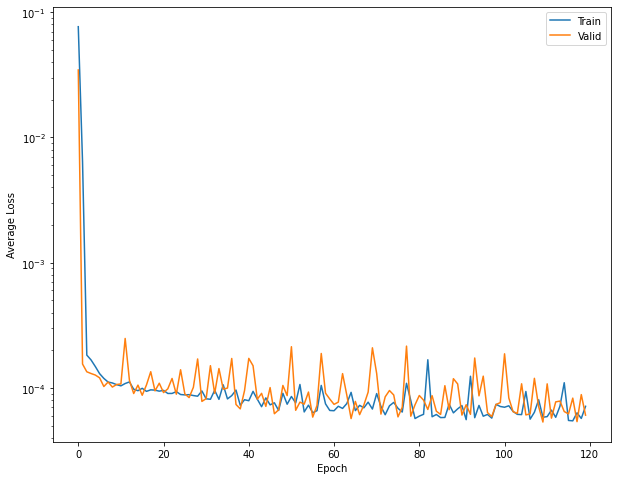

In [139]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

For image 0, the loss = 2.7608864911599085e-05
For image 1, the loss = 0.00017922947881743312
For image 2, the loss = 3.3103147870860994e-05
For image 3, the loss = 1.4408280549105257e-05
For image 4, the loss = 5.7274279242847115e-05
For image 5, the loss = 2.4430619305348955e-05
For image 6, the loss = 4.156491195317358e-05
For image 7, the loss = 8.945704757934436e-05
For image 8, the loss = 4.223091673338786e-05
For image 9, the loss = 3.99517739424482e-05


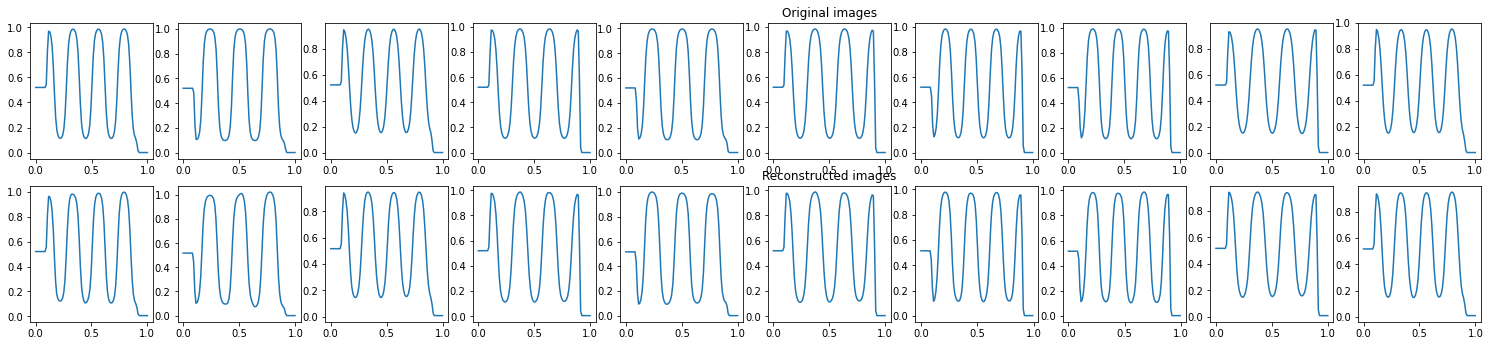

In [140]:
au.test(encoder,decoder,test_dataset,device,loss_fn,in_d1,in_d2,n=10)

tensor([-0.0890,  3.3775,  0.5894])
tensor([2.3169, 0.3949, 2.7857])


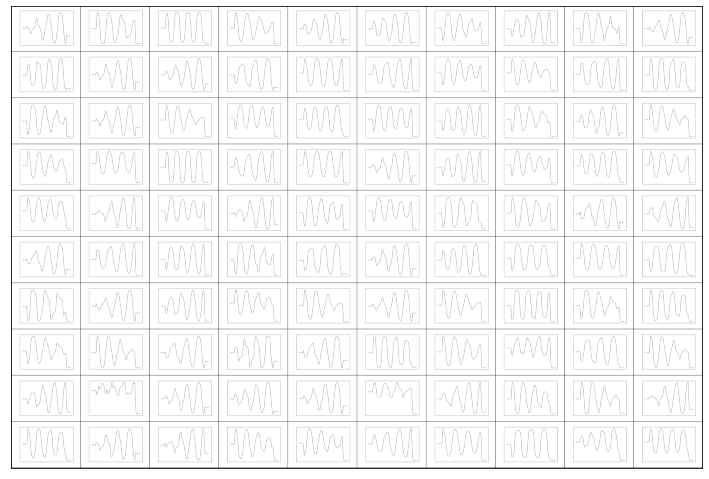

In [141]:
#Interpolating in the latent space
#This is similar to a manifold

def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    plt.close()
    img = cv2.imdecode(img_arr,0)

    return img

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_xticks([])
    ax.set_yticks([])

encoder.eval()
decoder.eval()

with torch.no_grad():
    images, labels = iter(train_loader).next()
    images = images.view(images.size(0), -1).to(device) 

    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)


    latent = torch.randn(200, d)*std + mean
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.view(img_recon.size(0), in_d1,in_d2).cpu()


n_img = []
for i in range(img_recon.shape[0]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.close()
    ax.plot(img_recon[i][0],img_recon[i][1])
    n_img.append(get_img_from_fig(fig))

n_img = torch.from_numpy(np.asarray(n_img))
n_img = n_img[:,np.newaxis,:,:]

fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(n_img[:100],10,5))
plt.show()

In [142]:
nlabel = params_arr.shape[1]
# nlabel

for i in range(nlabel):
  label_index = 'label'+str(i)
  print(label_index)

label0
label1
label2


In [143]:
encoded_samples = []
for sample in train_dataset:
    img = sample[0].unsqueeze(0)
    img = img.view(img.size(0), -1).to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    encoded_img = encoded_img.flatten().cpu().numpy()
    # print(enumerate(encoded_img))
    encoded_sample = {f"l{i+1}": enc for i, enc in enumerate(encoded_img)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      encoded_sample[label_index] = label_val[i].numpy()
    # encoded_sample['label1'] = label[1].numpy()
    # encoded_sample['label2'] = label[2].numpy()
    # encoded_sample['label3'] = label[3].numpy()
    encoded_samples.append(encoded_sample)
df_encoded_samples = pd.DataFrame(encoded_samples)
df_encoded_samples

,l1,l2,l3,label0,label1,label2
0,0.179695,2.937161,0.644347,0.16,0.448,0.27366
1,3.504156,2.887680,-0.847367,0.161,0.286,0.49129
2,-0.330752,3.657084,-3.061583,0.181,0.366,-0.05683
3,3.062656,2.944577,-0.594142,0.0843,0.293,0.08504
4,3.506454,2.885484,-0.826153,0.187,0.262,0.22025
...,...,...,...,...,...,...
4748,1.027727,2.914720,4.404636,0.106,-0.213,0.24861
4749,3.501592,2.887888,-0.848583,0.196,0.134,0.30213
4750,2.944934,2.961373,-0.537576,0.061,0.472,0.17051
4751,-3.144593,3.769327,2.328495,0.0944,-0.297,-0.10343


In [144]:
#Creating dataloaders for the MLP. This includes train, valid and test

img, out_img, train_latent_var, train_labels_var = au.get_latent_variables(encoder,decoder,device,train_loader)
print(img.shape, out_img.shape, train_latent_var.shape, train_labels_var.shape)

img, out_img, valid_latent_var, valid_labels_var = au.get_latent_variables(encoder,decoder,device,valid_loader)
print(img.shape, out_img.shape, valid_latent_var.shape, valid_labels_var.shape)


img, out_img, test_latent_var, test_labels_var = au.get_latent_variables(encoder,decoder,device,test_loader)
print(img.shape, out_img.shape, test_latent_var.shape, test_labels_var.shape)


mlp_train_dataset, mlp_valid_dataset, mlp_test_dataset, mlp_train_loader, mlp_valid_loader, mlp_test_loader = \
dpre.get_dataloaders_fromsplitarrays(train_latent_var.numpy(),train_labels_var.numpy(), \
                                valid_latent_var.numpy(),valid_labels_var.numpy(),\
                                test_latent_var.numpy(),test_labels_var.numpy(), \
                                batch_size=50)

torch.Size([4753, 192]) torch.Size([4753, 192]) torch.Size([4753, 3]) torch.Size([4753, 3])
torch.Size([594, 192]) torch.Size([594, 192]) torch.Size([594, 3]) torch.Size([594, 3])
torch.Size([595, 192]) torch.Size([595, 192]) torch.Size([595, 3]) torch.Size([595, 3])


In [145]:
# #Saving encoder and decoder 
# torch.save(encoder.state_dict(),"./encoder.pt")
# torch.save(decoder.state_dict(),"./decoder.pt")

In [146]:
# #Reloading the encoder and decoderen
# encoder.load_state_dict(torch.load("./encoder.pt"))
# decoder.load_state_dict(torch.load("./decoder.pt"))

In [147]:
num_epochs = 600
num_layers = 1
num_neur = 500

def initialize_mlp(dim,nlabel,num_layers,num_neur):
  lr= 0.001
  torch.manual_seed(0)
  
  model = mlp.MLP(dim=d,nlabel=nlabel,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': model.parameters()},
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return model, optim

In [148]:
# #Running the MLP
# ### Define the loss function 
# loss_fn = torch.nn.MSELoss()

# ### Define the learning rate
# lr= 0.001

# ### Set the random seed for reproducible results
# torch.manual_seed(0)

# #model 
# model = mlp.MLP(dim=d,nlabel=nlabel)
# params_to_optimize = [
#     {'params': model.parameters()}
# ]

# #Define the optimizer
# optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# #Checking the device
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print(f'Selected device: {device}')

In [149]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)
model.to(device)

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=3, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=3, bias=True)
  )
)

In [150]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)

#Train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = mlp.fit(model,device,mlp_train_loader,loss_fn,optim)
  val_loss = mlp.val(model,device,mlp_valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)

EPOCH 1/600 	 train loss 0.040250543504953384 	 val loss 0.02907530963420868
EPOCH 2/600 	 train loss 0.02236018143594265 	 val loss 0.024188727140426636
EPOCH 3/600 	 train loss 0.02113468386232853 	 val loss 0.020805714651942253
EPOCH 4/600 	 train loss 0.020830268040299416 	 val loss 0.023436440154910088
EPOCH 5/600 	 train loss 0.019755439832806587 	 val loss 0.019445080310106277
EPOCH 6/600 	 train loss 0.01894165389239788 	 val loss 0.01889466494321823
EPOCH 7/600 	 train loss 0.018275028094649315 	 val loss 0.02027413621544838
EPOCH 8/600 	 train loss 0.017961544916033745 	 val loss 0.016690602526068687
EPOCH 9/600 	 train loss 0.016886955127120018 	 val loss 0.016096655279397964
EPOCH 10/600 	 train loss 0.01692947931587696 	 val loss 0.016975730657577515
EPOCH 11/600 	 train loss 0.016780128702521324 	 val loss 0.019069798290729523
EPOCH 12/600 	 train loss 0.01715257577598095 	 val loss 0.016658801585435867
EPOCH 13/600 	 train loss 0.016813507303595543 	 val loss 0.017686827

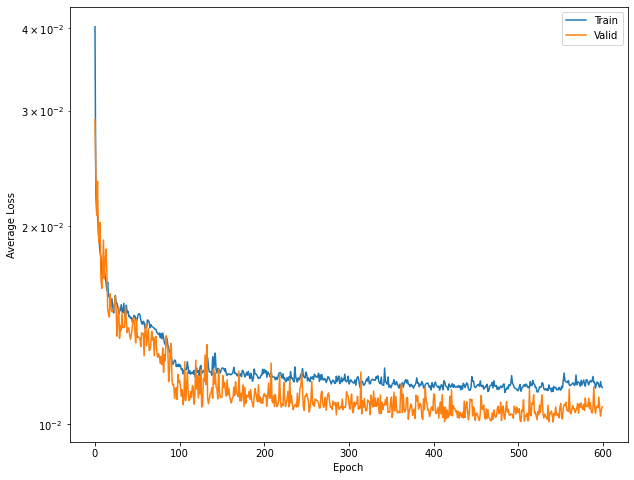

In [151]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [152]:
out_samples = []
for sample in mlp_test_dataset:
    img = sample[0]
    img = img.to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    model.eval()
    with torch.no_grad():
        out_label  = model(img)
    out_label = out_label.cpu().numpy()
    # print(enumerate(encoded_img))
    out_sample = {f"pred_label{i}": enc for i, enc in enumerate(out_label)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      out_sample[label_index] = label_val[i].numpy()
    out_samples.append(out_sample)
df_out_samples = pd.DataFrame(out_samples)
df_out_samples

,pred_label0,pred_label1,pred_label2,label0,label1,label2
0,0.145246,-0.198616,-0.369639,0.144,-0.0566,-0.31205
1,0.138785,0.214352,-0.296910,0.177,0.278,-0.4109
2,0.140400,-0.373598,-0.197492,0.18,-0.523,-0.39235
3,0.127854,-0.394012,-0.181558,0.104,-0.437,-0.22446
4,0.146545,-0.272353,-0.294135,0.121,-0.147,-0.18481
...,...,...,...,...,...,...
590,0.150437,-0.317595,0.410678,0.159,-0.123,0.39869
591,0.127426,-0.325105,0.388389,0.107,-0.547,0.35984
592,0.150996,-0.318091,0.415241,0.185,-0.536,0.39917
593,0.148396,-0.323810,0.097340,0.137,-0.542,0.08349


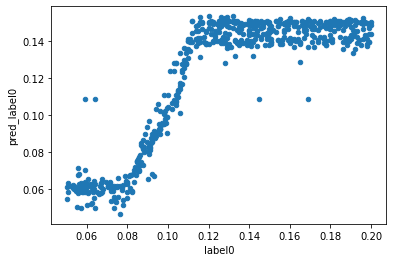

In [153]:
df_out_samples.plot(x ='label0', y='pred_label0', kind = 'scatter')
plt.show()

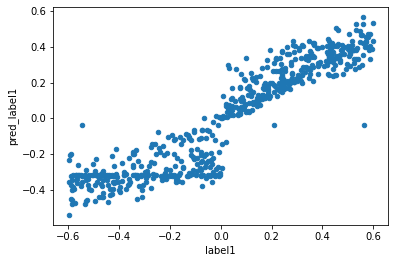

In [154]:
df_out_samples.plot(x ='label1', y='pred_label1', kind = 'scatter')
plt.show()

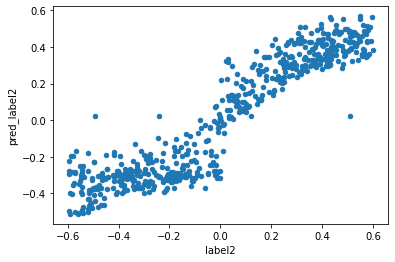

In [155]:
df_out_samples.plot(x ='label2', y='pred_label2', kind = 'scatter')
plt.show()

In [156]:
#Saving data into GitHub

# torch.save(train_latent_var,os.path.join(data_path,'train_latent_var.pt'))
# torch.save(train_latent_var,'train_labels_var.pt')

# torch.save(valid_latent_var,'valid_latent_var.pt')
# torch.save(valid_latent_var,'valid_labels_var.pt')

# torch.save(test_latent_var,'test_latent_var.pt')
# torch.save(test_latent_var,'test_labels_var.pt')


# torch.save(mlp_train_loader,'mlp_train_loader.pth')
# torch.save(mlp_valid_loader,'mlp_valid_loader.pth')
# torch.save(mlp_test_loader,'mlp_test_loader.pth')

# !mv mlp_train_loader.pth /content/drive/MyDrive/neutron_reflectivity/
# !mv mlp_valid_loader.pth /content/drive/MyDrive/neutron_reflectivity/
# !mv mlp_test_loader.pth /content/drive/MyDrive/neutron_reflectivity/

# torch.save(mlp_test_dataset,'mlp_test_dataset.pth')
# !mv mlp_test_dataset.pth /content/drive/MyDrive/neutron_reflectivity/

# #Saving also the pandas dataframe for the encoded sample

# #Having issues with the way a saved .csv and loaded one look like. 
# # df_encoded_samples.to_csv('encoded.csv', sep ='\t')
# # !mv encoded.csv /content/drive/MyDrive/neutron_reflectivity/

# #Using pickle instead.
# df_encoded_samples.to_pickle('df_encoded_samples.pkl')
# !mv df_encoded_samples.pkl /content/drive/MyDrive/neutron_reflectivity/

In [157]:
#Testing the model in experimental data
#Stored those numpy arrays
data_path = './exptdata/'

#Functions to read the sld and the param files
def read_sld_files(file_name):
    print(file_name)
    with open(file_name, 'r') as data:
        x = []
        y = []
        xy = [x,y]
        for line in data:
            p = line.split()
            # print(p)
            x.append(float(p[0]))
            y.append(float(p[1]))
            xy = x,y
            # array_xy = np.asarray(xy)

    return np.asarray(x),np.asarray(y)


folder = data_path


datafiles = [os.path.join(root, filename)
          for root, dirs, files in os.walk(folder)
          for filename in files
          if filename.lower().startswith('sld')]

for file in datafiles:
  dataindiv = read_sld_files(file)

dataindiv
# sld_arr = np.load(os.path.join(data_path,'sld_fp49.npy'))
# params_arr = np.load(os.path.join(data_path,'params_fp49.npy'))

./exptdata/sld_data.txt


(array([   0.    ,   19.7887,   39.5773,   59.366 ,   79.1546,   98.9433,
         118.732 ,  138.521 ,  158.309 ,  178.098 ,  197.887 ,  217.675 ,
         237.464 ,  257.253 ,  277.041 ,  296.83  ,  316.619 ,  336.407 ,
         356.196 ,  375.984 ,  395.773 ,  415.562 ,  435.35  ,  455.139 ,
         474.928 ,  494.716 ,  514.505 ,  534.294 ,  554.082 ,  573.871 ,
         593.66  ,  613.448 ,  633.237 ,  653.026 ,  672.814 ,  692.603 ,
         712.392 ,  732.18  ,  751.969 ,  771.758 ,  791.546 ,  811.335 ,
         831.124 ,  850.912 ,  870.701 ,  890.49  ,  910.278 ,  930.067 ,
         949.856 ,  969.644 ,  989.433 , 1009.22  , 1029.01  , 1048.8   ,
        1068.59  , 1088.38  , 1108.16  , 1127.95  , 1147.74  , 1167.53  ,
        1187.32  , 1207.11  , 1226.9   , 1246.69  , 1266.47  , 1286.26  ,
        1306.05  , 1325.84  , 1345.63  , 1365.42  , 1385.21  , 1404.99  ,
        1424.78  , 1444.57  , 1464.36  , 1484.15  , 1503.94  , 1523.73  ,
        1543.52  , 1563.3   , 1583.09 

In [158]:
print(len(datafiles))
print(type(dataindiv[0]))
dataindiv[1].shape


1
<class 'numpy.ndarray'>


(96,)

In [254]:
dataindv_arr = np.asarray(dataindiv)
# dataindv_arr.shape

exp_sld = []
exp_sld.append(dataindv_arr)
dataindv_arr[0] = dataindv_arr[0] + 250
exp_sld_arr = np.asarray(exp_sld)
exp_sld_arr.shape

print(dataindv_arr.shape)
#dataindv_arr[0] = dataindv_arr[0] + 250
dataindv_arr[0]

(2, 96)


array([ 250.    ,  269.7887,  289.5773,  309.366 ,  329.1546,  348.9433,
        368.732 ,  388.521 ,  408.309 ,  428.098 ,  447.887 ,  467.675 ,
        487.464 ,  507.253 ,  527.041 ,  546.83  ,  566.619 ,  586.407 ,
        606.196 ,  625.984 ,  645.773 ,  665.562 ,  685.35  ,  705.139 ,
        724.928 ,  744.716 ,  764.505 ,  784.294 ,  804.082 ,  823.871 ,
        843.66  ,  863.448 ,  883.237 ,  903.026 ,  922.814 ,  942.603 ,
        962.392 ,  982.18  , 1001.969 , 1021.758 , 1041.546 , 1061.335 ,
       1081.124 , 1100.912 , 1120.701 , 1140.49  , 1160.278 , 1180.067 ,
       1199.856 , 1219.644 , 1239.433 , 1259.22  , 1279.01  , 1298.8   ,
       1318.59  , 1338.38  , 1358.16  , 1377.95  , 1397.74  , 1417.53  ,
       1437.32  , 1457.11  , 1476.9   , 1496.69  , 1516.47  , 1536.26  ,
       1556.05  , 1575.84  , 1595.63  , 1615.42  , 1635.21  , 1654.99  ,
       1674.78  , 1694.57  , 1714.36  , 1734.15  , 1753.94  , 1773.73  ,
       1793.52  , 1813.3   , 1833.09  , 1852.88  , 

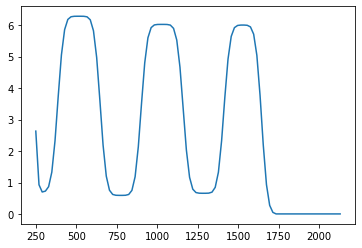

In [255]:
plt.plot(exp_sld_arr[0][0],exp_sld_arr[0][1])

In [256]:
#Normalizing the sld curves by min/max

#First finding the min/max
x_val=sld_arr[:,0,:]
x_min = x_val.min()
x_max = x_val.max()
print('x-range = ', x_min, ' to ',x_max)
y_val=sld_arr[:,1,:]
y_min = y_val.min()
y_max = y_val.max()
print('y-range = ', y_min, ' to ',y_max)

x-range =  0.0  to  1.0
y-range =  0.0  to  1.0


In [257]:
#Normalize
sld_arr[:,0,:] = (sld_arr[:,0,:] - x_min)/(x_max - x_min)
sld_arr[:,1,:] = (sld_arr[:,1,:] - y_min)/(y_max - y_min)

In [258]:
sld_arr.min(), sld_arr.max()

(0.0, 1.0)

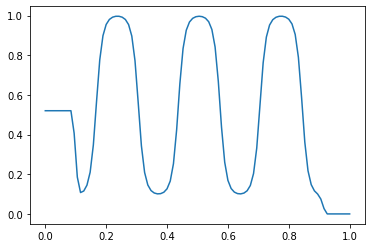

In [259]:
plt.plot(sld_arr[0][0],sld_arr[0][1])

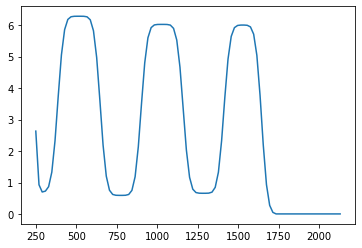

In [260]:
plt.plot(exp_sld_arr[0][0],exp_sld_arr[0][1])

In [261]:
x_val=exp_sld_arr[:,0,:]
x_min = x_val.min()
x_max = x_val.max()
print('x-range = ', x_min, ' to ',x_max)
y_val=exp_sld_arr[:,1,:]
y_min = y_val.min()
y_max = y_val.max()
print('y-range = ', y_min, ' to ',y_max)

exp_sld_arr[:,0,:] = (exp_sld_arr[:,0,:] - x_min)/(x_max - x_min)
exp_sld_arr[:,1,:] = (exp_sld_arr[:,1,:] - y_min)/(y_max - y_min)

x-range =  250.0  to  2129.92
y-range =  0.00808414  to  6.2808628569


In [262]:
encoder.eval().to(device)

Encoder(
  (encoder): Sequential(
    (0): Linear(in_features=192, out_features=150, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=150, out_features=150, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=150, out_features=3, bias=True)
  )
)

In [263]:
decoder.eval().to(device)

Decoder(
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=150, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=150, out_features=150, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=150, out_features=192, bias=True)
  )
)

In [264]:
img = torch.from_numpy(exp_sld_arr).float()
img = img.view(img.size(0), -1).to(device)

In [265]:
encoder.eval()
decoder.eval()
with torch.no_grad(): 
  latent = encoder(img)
  decoded_img = decoder(latent)


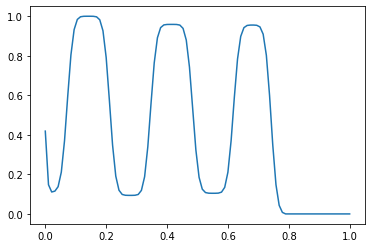

In [266]:
plt.plot(img.cpu().reshape(in_d1,in_d2).numpy()[0],img.cpu().reshape(in_d1,in_d2).numpy()[1]) 

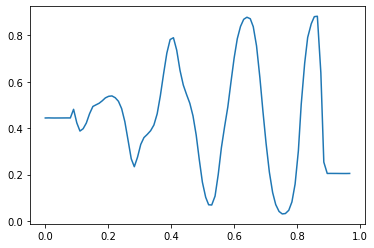

In [267]:
plt.plot(decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1]) 


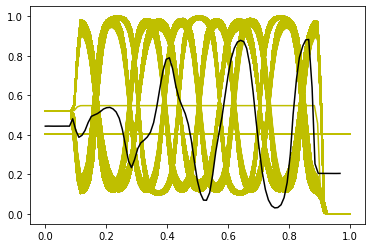

In [268]:
for x in range(sld_arr.shape[0]):
  plt.plot(sld_arr[x][0], sld_arr[x][1], 'y')
plt.plot(decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1], 'k') 
plt.show()

In [ ]:
type(sld_arr)